In [30]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import numpy as np

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
def get_data(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader


In [33]:
import torch.nn as nn
import torchvision.models as models

def get_model():
    model = models.vgg16(pretrained=True)  # Use a pre-trained VGG16 model
    model.classifier[6] = nn.Linear(4096, 10)  # Modify the output layer to have 10 classes
    model = model.to(device)
    
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

    return model, loss_fn, optimizer


In [34]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
        predicted_labels = torch.argmax(prediction, dim=1)
        is_correct = (predicted_labels == y)
    return is_correct.cpu().numpy()


In [35]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

Files already downloaded and verified
Files already downloaded and verified


tensor(1)


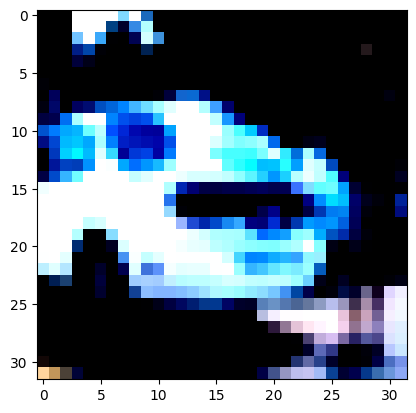

In [52]:
batch = next(iter(trn_dl))
xs, ys = batch
im = xs[0]
label = ys[0]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [37]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for batch in trn_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    
    train_epoch_loss = np.mean(train_epoch_losses)

    for batch in trn_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for batch in val_dl:
        x, y = batch
        x, y = x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

 epoch 1/5
Train Loss: 0.6912, Train Accuracy: 0.8589, Validation Accuracy: 0.8113
 epoch 2/5
Train Loss: 0.3681, Train Accuracy: 0.9365, Validation Accuracy: 0.8635
 epoch 3/5
Train Loss: 0.2396, Train Accuracy: 0.9624, Validation Accuracy: 0.8726
 epoch 4/5
Train Loss: 0.1729, Train Accuracy: 0.9717, Validation Accuracy: 0.8715
 epoch 5/5
Train Loss: 0.1312, Train Accuracy: 0.9585, Validation Accuracy: 0.8511


/tmp/ipykernel_34/589482731.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


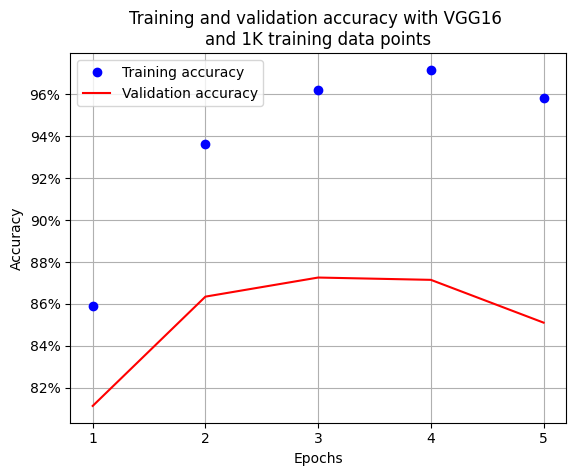

In [38]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()